# Hypothesis testing validation

Power analysis for DM, DV, and DC

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/schypo')
import estimator, simulate, schypo, bootstrap, util, hypothesis_test

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [4]:
data_path = '/data/parameter_estimation/'

fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig3/'

### Read the interferon data

In [5]:
ifn_adata = sc.read(data_path + 'interferon_filtered.h5ad')


### Calibration on real data

In [6]:
q = 0.07

In [85]:
cal_adata = ifn_adata[ifn_adata.obs.cell == 'CD4 T cells'].copy()
# cal_adata.obs['stim'] = np.random.choice(['stim', 'ctrl'], cal_adata.shape[0])

In [86]:
cal_adata.shape

(10342, 35635)

In [87]:
schypo.create_groups(
    cal_adata,
    q=q,
    label_columns=['stim', 'ind'], 
    inplace=True)
schypo.compute_1d_moments(
    cal_adata, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.05, 
    min_perc_group=.9)
print(cal_adata.shape)
schypo.ht_1d_moments(
	cal_adata, 
	formula_like='1 + stim',
	cov_column='stim',
	num_boot=1000,
    num_cpus=6,
    verbose=3)

(10342, 1719)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 428 tasks      | elapsed:    8.7s
[Parallel(n_jobs=6)]: Done 1068 tasks      | elapsed:   22.1s
[Parallel(n_jobs=6)]: Done 1708 out of 1719 | elapsed:   35.4s remaining:    0.2s
[Parallel(n_jobs=6)]: Done 1719 out of 1719 | elapsed:   35.5s finished


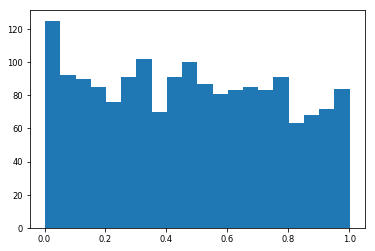

In [88]:
plt.hist(cal_adata.uns['schypo']['1d_ht']['var_asl'], bins=20);

In [ ]:
plt.hist(cal_adata.uns['schypo']['1d_ht']['mean_asl'], bins=20);

### Simulate some data

1000 genes total, 100 are DE and 100 are DV

In [93]:
adata = ifn_adata[ifn_adata.obs.cell_type == 'CD4 T cells - ctrl']
# data = adata.X.copy()
# relative_data = data.toarray()/data.sum(axis=1)

n_cells = 10000
q=0.07
x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q)

In [92]:
def simulate_two_datasets(x_param, Nc, n_cells, q, diff='mean'):
    
    log_means_1, log_variances_1 = np.log(x_param[0]), np.log(x_param[1])
    log_means_2, log_variances_2 = log_means_1.copy(), log_variances_1.copy()
    
    if diff == 'null':
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'mean':
        log_means_2 += 0.5
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'variability':
        log_variances_2 += 0.5
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'correlation':
        norm_cov_1 = make_spd_matrix(log_means_1.shape[0])
        norm_corr_1 = norm_cov_1/np.outer(np.sqrt(np.diag(norm_cov_1)), np.sqrt(np.diag(norm_cov_1)))
        norm_corr_subset = norm_corr_1[:50, :50]
        change_indices = np.where(norm_corr_subset < 0.5)
        norm_corr_subset[norm_corr_subset < 0.5][300] += 0.5
        
        norm_corr_2 = norm_corr_1.copy()
        norm_corr_2[:50, :50] = norm_corr_subset
        norm_cov_2 = norm_corr_2 * np.outer(np.sqrt(np.diag(norm_cov_1)), np.sqrt(np.diag(norm_cov_1)))
    
    data_1 = simulate.simulate_transcriptomes(
        n_cells=n_cells, 
        means=np.exp(log_means_1)*Nc.mean(),
        variances=(np.exp(log_variances_1) + np.exp(log_means_1)**2)*(Nc**2).mean() - np.exp(log_means_1)**2*Nc.mean()**2,
        Nc=Nc,
        norm_cov=norm_cov_1)
    
    data_2 = simulate.simulate_transcriptomes(
        n_cells=n_cells, 
        means=np.exp(log_means_2)*Nc.mean(),
        variances=(np.exp(log_variances_2) + np.exp(log_means_2)**2)*(Nc**2).mean() - np.exp(log_means_2)**2*Nc.mean()**2,
        Nc=Nc,
        norm_cov=norm_cov_2)
    
    true_data = np.vstack([data_1, data_2])
    _, hyper_captured = simulate.capture_sampling(true_data, q=q, process='hyper')
    
    anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
    anndata.obs['ct_real'] = ['A' for i in range(n_cells)] + ['B' for i in range(n_cells)]
    anndata.obs['ct_shuffled'] = np.random.choice(['A', 'B'], anndata.shape[0])
    
    if diff == 'correlation':
        return anndata, change_indices
    else:
        return anndata, None

    
def calculate_power(n_cells, test='mean', test_null=False):
    
    sim_adata, change_indices = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff=test if not test_null else 'null')
        
    schypo.create_groups(
        sim_adata,
        q=q,
        label_columns=['ct_real'], 
        inplace=True)
    
    schypo.compute_1d_moments(
        sim_adata, 
        inplace=True, 
        filter_genes=False, 
        residual_var=True,
        filter_mean_thresh=0.0, 
        min_perc_group=.9)
        
    if test == 'mean':

        schypo.ht_1d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=10000,
            num_cpus=6,
            verbose=3)

        power = (sim_adata.uns['schypo']['1d_ht']['mean_asl'][:300] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['1d_ht']['mean_asl']
        
    if test == 'variability':

        schypo.ht_1d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=10000,
            num_cpus=6,
            verbose=3)
        
        power = (sim_adata.uns['schypo']['1d_ht']['var_asl'][:300] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['1d_ht']['var_asl']
        
    if test == 'correlation':
        
        schypo.compute_2d_moments(
            sim_adata, 
            inplace=True, 
            gene_1=np.arange(50).astype(str).tolist(),
            gene_2=np.arange(50).astype(str).tolist())
        
        schypo.ht_2d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=10000,
            num_cpus=6,
            verbose=3)
        
        c_pv = sim_adata.uns['schypo']['2d_ht']['corr_asl'][:50, :50]
        power = (c_pv[change_indices] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['2d_ht']['corr_asl']
                
    return power, pvals, sim_adata

In [ ]:
mean_power, var_power, corr_power = [], [], []
n_cells_list = np.logspace(2, 5, 25).astype(int)
for n_cells in n_cells_list:
    
    print(n_cells)
    
    mean_power.append(calculate_power(n_cells, test='mean')[0])
    var_power.append(calculate_power(n_cells, test='variability')[0])
    corr_power.append(calculate_power(n_cells, test='correlation')[0])

with open('temp.pkl', 'wb') as f:
    pkl.dump([mean_power, var_power, corr_power], f)

In [76]:
# with open('temp.pkl', 'wb') as f:
#     pkl.dump([mean_power, var_power, corr_power], f)

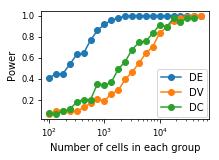

In [39]:
plt.figure(figsize=(3, 2))
plt.plot(n_cells_list[:23], mean_power, '-o')
plt.plot(n_cells_list[:23], var_power, '-o')
plt.plot(n_cells_list[:22], corr_power, '-o')
plt.xscale('log')
plt.xlabel('Number of cells in each group')
plt.ylabel('Power')
plt.legend(['DE', 'DV', 'DC'], loc='lower right', bbox_to_anchor=(0.52, -0.02, 0.5, 0.5))
plt.savefig(fig_path + 'power.pdf', bbox_inches='tight')

### HT on actual labels

In [90]:
mean_adata.shape

NameError: name 'mean_adata' is not defined

In [135]:
imp.reload(simulate)

<module 'simulate' from '/data/home/Github/scrna-parameter-estimation/schypo/simulate.py'>

In [136]:
x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q)

In [137]:
sim_adata, change_indices = simulate_two_datasets(x_param, Nc, 5000, q=q, diff='null')

In [138]:

cal_adata = sim_adata.copy()
cal_adata.obs['ct_real'] = np.random.choice(cal_adata.obs['ct_real'], cal_adata.shape[0])

In [139]:
schypo.create_groups(
    cal_adata,
    q=q,
    label_columns=['ct_real'], 
    inplace=True)
schypo.compute_1d_moments(
    cal_adata, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.00001, 
    min_perc_group=.9)
print(cal_adata.shape)
schypo.ht_1d_moments(
	cal_adata, 
	formula_like='1 + ct_real',
	cov_column='ct_real',
	num_boot=1000,
    num_cpus=6,
    verbose=3)

(10000, 10800)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 156 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 1884 tasks      | elapsed:    8.0s
[Parallel(n_jobs=6)]: Done 4764 tasks      | elapsed:   19.7s
[Parallel(n_jobs=6)]: Done 8796 tasks      | elapsed:   36.2s
[Parallel(n_jobs=6)]: Done 10800 out of 10800 | elapsed:   44.1s finished


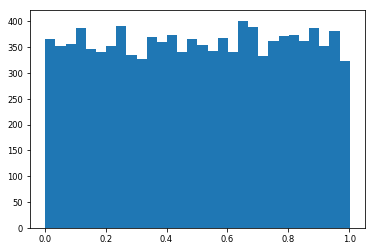

In [140]:
plt.hist(cal_adata.uns['schypo']['1d_ht']['mean_asl'], bins=30);

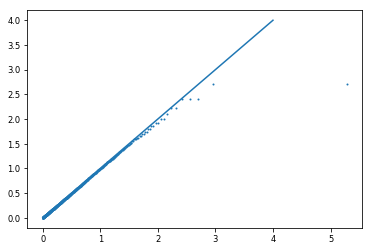

In [141]:
plt.scatter(
    np.quantile(-np.log10(stats.uniform.rvs(0, 1, 100000)), np.linspace(0, 1, 1000)),
    np.quantile(-np.log10(cal_adata.uns['schypo']['1d_ht']['mean_asl']), np.linspace(0, 1, 1000)), s=1)
plt.plot([0, 4], [0, 4])

In [91]:
_, mean_pval, mean_adata = calculate_power(5000, test='mean')
# _, var_pval, var_adata = calculate_power(5000, test='variability')
# _, corr_pval, corr_adata = calculate_power(5000, test='correlation')

NameError: name 'calculate_power' is not defined

(array([131., 133., 181., 171., 184., 189., 191., 199., 226., 202.]),
 array([7.99920008e-04, 1.00689931e-01, 2.00579942e-01, 3.00469953e-01,
        4.00359964e-01, 5.00249975e-01, 6.00139986e-01, 7.00029997e-01,
        7.99920008e-01, 8.99810019e-01, 9.99700030e-01]),
 <a list of 10 Patch objects>)

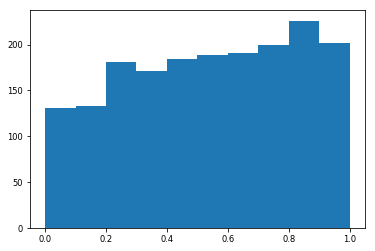

In [19]:
plt.hist(mean_pval)

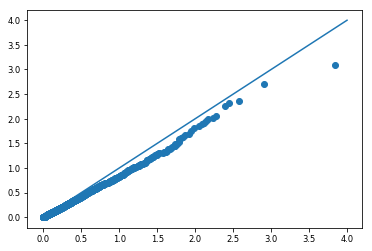

In [31]:
plt.scatter(
    np.quantile(-np.log10(stats.uniform.rvs(0, 1, 5000)), np.linspace(0, 1, 1000)),
    np.quantile(-np.log10(mean_pval), np.linspace(0, 1, 1000)))
plt.plot([0, 4], [0, 4])

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


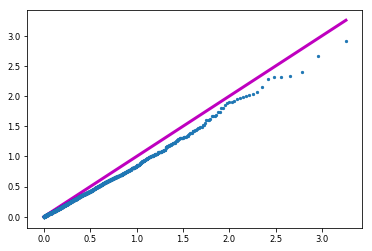

In [21]:
plt.plot(-np.log10(np.linspace(0, 1, mean_pval.shape[0])),-np.log10(np.linspace(0, 1, mean_pval.shape[0])), lw=3, color='m', zorder=-1)

plt.scatter(-np.log10(np.linspace(0, 1, mean_pval.shape[0])), -np.log10(np.sort(mean_pval)), s=5)


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


(0, 8)

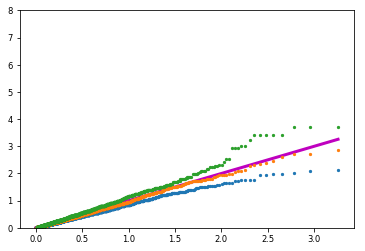

In [14]:
plt.plot(-np.log10(np.linspace(0, 1, mean_pval.shape[0])),-np.log10(np.linspace(0, 1, mean_pval.shape[0])), lw=3, color='m', zorder=-1)

plt.scatter(-np.log10(np.linspace(0, 1, mean_pval.shape[0])), -np.log10(np.sort(mean_pval)), s=5)
plt.scatter(-np.log10(np.linspace(0, 1, mean_pval.shape[0])), -np.log10(np.sort(var_pval)), s=5)
plt.scatter(-np.log10(np.linspace(0, 1, mean_pval.shape[0])), -np.log10(np.sort(corr_pval.ravel()[:mean_pval.shape[0]])), s=5)

plt.ylim(0, 8)



In [48]:
mean_pval

array([0.23576424, 0.3016983 , 0.55344655, ..., 0.84915085, 0.84115884,
       0.6033966 ])

In [47]:
n_cells

56234

In [10]:
adata_scmemo = adata.copy()
adata_scmemo.X = adata_scmemo.X.astype(np.int64)
scmemo.create_groups(adata_scmemo, label_columns=['ct_real'], inplace=True)
scmemo.compute_1d_moments(adata_scmemo, inplace=True, filter_genes=True, residual_var=True, use_n_umi=False, filter_mean_thresh=0.2, min_perc_group=.9)

In [11]:
%%time
imp.reload(hypothesis_test)
imp.reload(scmemo)
imp.reload(estimator)
imp.reload(bootstrap)
scmemo.ht_1d_moments(
	adata_scmemo, 
	formula_like='1 + ct_real',
	cov_column='ct_real',
	use_residual_var=True, 
	num_boot=50000, 
	dirichlet_approx=True,
    log=True,
    verbose=True)

On gene idx 0
On gene idx 300
CPU times: user 10min 26s, sys: 9min, total: 19min 27s
Wall time: 7min 42s


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


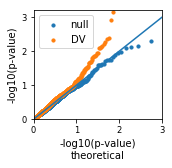

In [12]:
plt.figure(figsize=(2.3, 2))
plt.scatter(
    -np.log10(np.linspace(0, 1, adata_scmemo.uns['scmemo']['1d_ht']['mean_asl'].shape[0])), 
    -np.log10(np.sort(adata_scmemo.uns['scmemo']['1d_ht']['mean_asl'])), s=10, label='null')
plt.scatter(
    -np.log10(np.linspace(0, 1, adata_scmemo.uns['scmemo']['1d_ht']['var_asl'].shape[0])), 
    -np.log10(np.sort(adata_scmemo.uns['scmemo']['1d_ht']['var_asl'])), s=10, label='DV')
plt.plot([0, 4], [0, 4])
plt.xlim(0,3)
plt.ylim(0,3.2)
plt.legend()
plt.xlabel('-log10(p-value)\ntheoretical')
plt.ylabel('-log10(p-value)')
plt.savefig(fig_path + 'pvalue_qq_plot.pdf', bbox_inches='tight')